# Time-series forecasting using BigQuery

This notebook walks through the following flow:

1 Building a machine learning (ML) forecasting model locally
* Create features and labels on a subsample of data
* Train a model using sklearn

2 Building and scaling out a ML using Google BigQuery 
* Create features and labels on the full dataset using BigQuery.
* Train the model on the entire dataset using BigQuery ML

3 Building an advanced forecasting modeling using recurrent neural network (RNN) model
* Create features and labels on the full dataset using BigQuery.
* Train a model using TensorFlow

## Rolling window for time-series forecasting

In this notebook we will run a sliding window setup to create feature windows. 

We have created a Pandas solution `create_rolling_features_label` function that automatically creates the features/label setup. This is suitable for smaller datasets and for local testing before training on the Cloud. And we have also created a BigQuery script that creates these rolling windows suitable for large datasets.

![](rolling_window.gif)

## Data Exploration

Import libraries.

In [53]:
%matplotlib inline
import pandas as pd

import time_series

In [ ]:
# Allow you to easily have Python variables in SQL query.
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
@register_cell_magic('with_globals')
def with_globals(line, cell):
    contents = cell.format(**globals())
    if 'print' in line:
        print(contents)
    get_ipython().run_cell(contents)

For this demo we will be using New York City real estate data obtained from [nyc.gov](https://www1.nyc.gov/site/finance/taxes/property-annualized-sales-update.page). The data starts in 2003. But since we are just doing local modeling, let's just use a subsample of the data. Later we will train on all of the data in the cloud.

Please see the appendix on how to load the data into BigQuery.

In [50]:
SOURCE_TABLE = 'nyc_real_estate.all_sales'
PROJECT = 'asl-testing-217717'
DATASET = 'nyc_real_estate'
BUCKET = 'asl-testing-bucket'
FILTER = "residential_units = 1 AND sale_price > 10000 AND sale_date > TIMESTAMP('2010-12-31 00:00:00')"

In [51]:
%%with_globals
%%bigquery --project {PROJECT} df
SELECT sale_date, * EXCEPT (sale_date)
FROM {SOURCE_TABLE}
WHERE {FILTER}
ORDER BY sale_date
LIMIT 100

In [52]:
df.head()

,sale_date,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease_ment,building_class_at_present,address,...,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,price_per_sq_ft
0,2011-01-01 00:00:00+00:00,1,UPPER WEST SIDE (79-96),13 CONDOS - ELEVATOR APARTMENTS,2,1229,1170,,R4,219 WEST 81ST STREET,...,1.0,0.0,1.0,0.0,0.0,1912,2,R4,134640,inf
1,2011-01-03 00:00:00+00:00,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,695,1572,,R4,555 WEST 23RD STREET,...,1.0,0.0,1.0,0.0,0.0,2005,2,R4,767500,inf
2,2011-01-03 00:00:00+00:00,1,MURRAY HILL,13 CONDOS - ELEVATOR APARTMENTS,2,912,1190,,R4,200 EAST 32ND STREET,...,1.0,0.0,1.0,0.0,0.0,0,2,R4,999000,inf
3,2011-01-03 00:00:00+00:00,1,SOHO,13 CONDOS - ELEVATOR APARTMENTS,2,594,1329,,R4,505 GREENWICH STREET,...,1.0,0.0,1.0,0.0,0.0,0,2,R4,1525000,inf
4,2011-01-03 00:00:00+00:00,1,MIDTOWN WEST,13 CONDOS - ELEVATOR APARTMENTS,2,1272,1019,,R4,33 WEST 56TH STREET,...,1.0,0.0,1.0,0.0,0.0,0,2,R4,1978459,inf


In [54]:
%%with_globals
%%bigquery --project {PROJECT} df
SELECT neighborhood, count(*) as cnt
FROM {SOURCE_TABLE}
WHERE {FILTER}
GROUP BY neighborhood
ORDER by cnt

The most sales are from the upper west side, midtown west, and the upper east side.

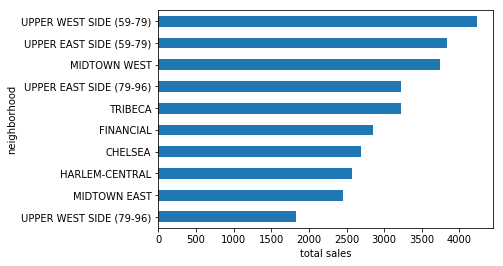

In [55]:
ax = df.set_index('neighborhood').cnt\
    .tail(10)\
    .plot(kind='barh');
ax.set_xlabel('total sales');

SOHO and Civic Center are the most expensive neighborhoods.

In [56]:
%%with_globals
%%bigquery --project {PROJECT} df
SELECT neighborhood, APPROX_QUANTILES(sale_price, 100)[OFFSET(50)] AS median_price
FROM {SOURCE_TABLE}
WHERE {FILTER}
GROUP BY neighborhood
ORDER by median_price

Text(0.5, 0, 'median price')

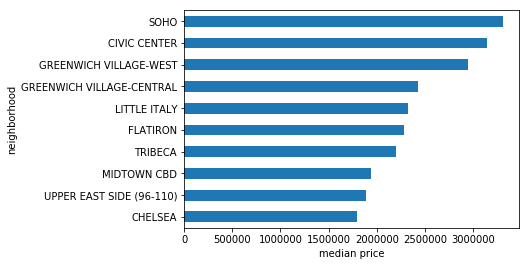

In [57]:
ax = df.set_index('neighborhood').median_price\
    .tail(10)\
    .plot(kind='barh');
ax.set_xlabel('median price')

## Build features

Let's create features for building a machine learning model:

1. Aggregate median sales for each week. Prices are noisy and by grouping by week, we will smooth out irregularities.
2. Create a rolling window to split the single long time series into smaller windows. One feature vector will contain a single window and the label will be a single observation (or window for multiple predictions) occuring after the window.

In [58]:
%%with_globals
%%bigquery --project asl-testing-217717 df
SELECT sale_week, APPROX_QUANTILES(sale_price, 100)[OFFSET(50)] AS median_price
FROM (
    SELECT timestamp_trunc(sale_date, week) AS sale_week, sale_price
    FROM {SOURCE_TABLE}
    WHERE {FILTER})
GROUP BY sale_week
ORDER BY sale_week

In [59]:
sales = pd.Series(df.median_price)
sales.index= pd.DatetimeIndex(df.sale_week.dt.date)
sales.head()

sale_week
2010-12-26     134640
2011-01-02    1150000
2011-01-09     945000
2011-01-16     995000
2011-01-23    1150000
Name: median_price, dtype: int64

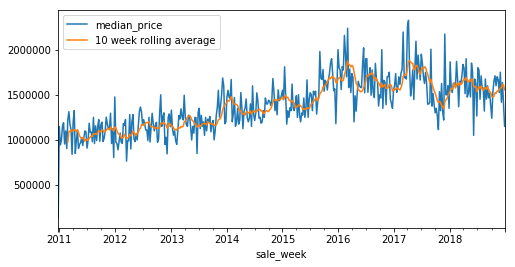

In [60]:
ax = sales.plot(figsize=(8,4), label='median_price')
ax = sales.rolling(10).mean().plot(ax=ax, label='10 week rolling average')
ax.legend()

### Sliding window

Let's create our features. We will use the `create_rolling_features_label` function that automatically creates the features/label setup.

![](rolling_window.gif)

Create the features and labels.

In [62]:
WINDOW_SIZE = 52 * 1
HORIZON = 4*6
MONTHS = 0
WEEKS = 1
LABELS_SIZE = 1
df = time_series.create_rolling_features_label(sales, window_size=WINDOW_SIZE, pred_offset=HORIZON)
df = time_series.add_date_features(df, df.index, months=MONTHS, weeks=WEEKS)
df.head()

/home/jupyter/forecasting/time_series.py:98: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  .apply(_keep, args=(windows,))


,-75_steps,-74_steps,-73_steps,-72_steps,-71_steps,-70_steps,-69_steps,-68_steps,-67_steps,-66_steps,...,-27_steps,-26_steps,-25_steps,-24_steps,label,doy,dom,month,year,n_holidays
pred_date,,,,,,,,,,,,,,,,,,,,,
2012-06-03,134640.0,1150000.0,945000.0,995000.0,1150000.0,1190000.0,955000.0,1100000.0,903696.0,1220000.0,...,1120075.0,1295000.0,960000.0,1125000.0,1160000.0,155,3,6,2012,0
2012-06-10,1150000.0,945000.0,995000.0,1150000.0,1190000.0,955000.0,1100000.0,903696.0,1220000.0,1313542.0,...,1295000.0,960000.0,1125000.0,805000.0,1313542.0,162,10,6,2012,0
2012-06-17,945000.0,995000.0,1150000.0,1190000.0,955000.0,1100000.0,903696.0,1220000.0,1313542.0,1175000.0,...,960000.0,1125000.0,805000.0,1476462.0,1365000.0,169,17,6,2012,0
2012-06-24,995000.0,1150000.0,1190000.0,955000.0,1100000.0,903696.0,1220000.0,1313542.0,1175000.0,1114000.0,...,1125000.0,805000.0,1476462.0,975000.0,1310000.0,176,24,6,2012,0
2012-07-01,1150000.0,1190000.0,955000.0,1100000.0,903696.0,1220000.0,1313542.0,1175000.0,1114000.0,840000.0,...,805000.0,1476462.0,975000.0,960000.0,1168441.0,183,1,7,2012,1


Let's train our model using all weekly median prices from 2003 -- 2015. Then we will test our model's performance on prices from 2016 -- 2018

In [63]:
# Features, label.
X = df.drop('label', axis=1)
y = df['label']

# Train/test split. Splitting on time.
train_ix = time_series.is_between_dates(y.index,
                                  end='2015-12-30')
test_ix = time_series.is_between_dates(y.index,
                                 start='2015-12-30',
                                 end='2018-12-30 08:00:00')
X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
X_test, y_test = X.iloc[test_ix], y.iloc[test_ix]

print(X_train.shape, X_test.shape)

(187, 57) (157, 57)


Z-score normalization for the features for training.

In [64]:
mean = X_train.mean()
std = X_train.std()

def zscore(X):
    return (X-mean)/std

X_train = zscore(X_train)
X_test = zscore(X_test)

## Initial model

### Baseline
Build naive model that just uses the mean of training set.

In [65]:
df_baseline = y_test.to_frame(name='label')
df_baseline['pred'] = y_train.mean()

In [66]:
# Join mean predictions with test labels.
baseline_global_metrics = time_series.Metrics(df_baseline.pred,
                                              df_baseline.label)
baseline_global_metrics.report("Global Baseline Model")

Global Baseline Model results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RMSE: 376544.261
MAE: 316352.450
MALR: 0.207


In [67]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

In [68]:
# Train model.
cl = RandomForestRegressor(n_estimators=500, max_features='sqrt',
                              random_state=10, criterion='mse')
cl = Ridge(100)
cl = GradientBoostingRegressor ()

cl.fit(X_train, y_train)
pred = cl.predict(X_test)
random_forest_metrics = time_series.Metrics(y_test,
                                            pred)
random_forest_metrics.report("Forest Model")

Forest Model results
~~~~~~~~~~~~~~~~~~~~
RMSE: 259388.403
MAE: 202647.688
MALR: 0.125


The regression model performs 35% better than the baseline model.

Observations:
* Linear Regression does okay for this dataset (Regularization helps generalize the model)
* Random Forest is better -- doesn't require a lot of tuning. It performs a bit better than regression.
* Gradient Boosting does do better than regression

## Interpret results

,baseline,pred,y_test
pred_date,,,
2016-01-03,1.326630e+06,1.564678e+06,2000861.0
2016-01-10,1.326630e+06,1.538792e+06,1800000.0
2016-01-17,1.326630e+06,1.531224e+06,1775000.0
2016-01-24,1.326630e+06,1.459826e+06,1558026.0
2016-01-31,1.326630e+06,1.613824e+06,1812000.0


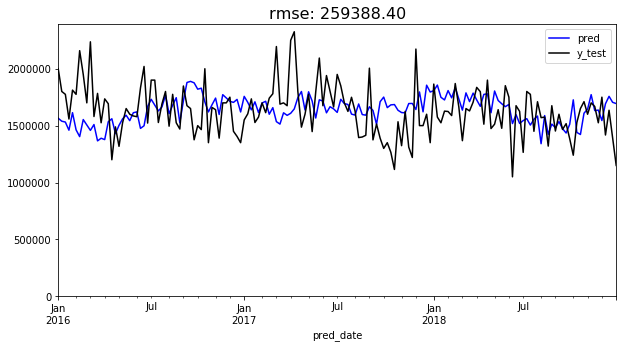

In [69]:
# Data frame to query for plotting
df_res = pd.DataFrame({'pred': pred, 'baseline': df_baseline.pred, 'y_test': y_test})
metrics = time_series.Metrics(df_res.y_test, df_res.pred)
ax = df_res.iloc[:].plot(y=[ 'pred', 'y_test'],
                 style=['b-','k-'],
                 figsize=(10,5))
ax.set_title('rmse: {:2.2f}'.format(metrics.rmse), size=16);
ax.set_ylim(20,)
df_res.head()

# BigQuery modeling

We have observed there is signal in our data and our smaller, local model is working better. Let's scale this model out to the cloud. Let's train a BigQuery Machine Learning (BQML) on the full-dataset

In [70]:
import scalable_time_series

In [71]:
value_name = "med_sales_price"
downsample_size = 7 # 7 days into 1 week
window_size = 52
labels_size = 1
horizon = 1

In [72]:
# Import BigQuery module
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client()

# Set dataset_id to the ID of the dataset to create.
sink_dataset_name = "temp_forecasting_dataset"
dataset_id = "{}.{}".format(client.project, sink_dataset_name)

# Construct a full Dataset object to send to the API.
dataset = bigquery.Dataset.from_string(dataset_id)

# Specify the geographic location where the dataset should reside.
dataset.location = "US"

# Send the dataset to the API for creation.
# Raises google.api_core.exceptions.Conflict if the Dataset already
# exists within the project.
try:
    dataset = client.create_dataset(dataset)  # API request
    print("Created dataset {}.{}".format(client.project, dataset.dataset_id))
except:
    print("Dataset {}.{} already exists".format(client.project, dataset.dataset_id))

Dataset asl-testing-217717.temp_forecasting_dataset already exists


We need to create a date range table in BigQuery so that we can join our data to that to get the correct sequences.

In [74]:
# Call BigQuery and examine in dataframe
source_dataset = "nyc_real_estate"
source_table_name = "all_sales"
query_create_date_range = scalable_time_series.create_date_range(client.project, source_dataset, source_table_name)
df = client.query(query_create_date_range + "LIMIT 100").to_dataframe()
df.head(5)

,timescale_idx,unix_timescale_start_date,unix_timescale_end_date,timescale_start_date,timescale_end_date
0,0,12053,12059,2003-01-01,2003-01-07
1,1,12054,12060,2003-01-02,2003-01-08
2,2,12055,12061,2003-01-03,2003-01-09
3,3,12056,12062,2003-01-04,2003-01-10
4,4,12057,12063,2003-01-05,2003-01-11


Execute query and write to BigQuery table.

In [75]:
job_config = bigquery.QueryJobConfig()
# Set the destination table
table_name = "start_end_timescale_date_range"
table_ref = client.dataset(sink_dataset_name).table(table_name)
job_config.destination = table_ref
job_config.write_disposition = "WRITE_TRUNCATE"

# Start the query, passing in the extra configuration.
query_job = client.query(
    query=query_create_date_range,
    # Location must match that of the dataset(s) referenced in the query
    # and of the destination table.
    location="US",
    job_config=job_config)  # API request - starts the query

query_job.result()  # Waits for the query to finish
print("Query results loaded to table {}".format(table_ref.path))

Query results loaded to table /projects/asl-testing-217717/datasets/temp_forecasting_dataset/tables/start_end_timescale_date_range


Now that we have the date range table created we can create our training dataset for BQML.

In [76]:
# Call BigQuery and examine in dataframe
sales_dataset_table = source_dataset + "." + source_table_name
query_bq_sub_sequences = scalable_time_series.bq_create_rolling_features_label(client.project, sink_dataset_name, table_name, sales_dataset_table, value_name, downsample_size, window_size, horizon, labels_size)
print(query_bq_sub_sequences[0:500])


WITH
  # Create sequence date ranges
  CTE_seq_date_ranges AS (
  SELECT
    A.timescale_idx AS seq_idx,
    ROW_NUMBER() OVER (PARTITION BY A.timescale_idx ORDER BY B.unix_timescale_start_date) - 1 AS timestep_idx,
    B.timescale_idx AS timescale_idx,
    A.unix_timescale_start_date AS seq_unix_start_date,
    B.unix_timescale_start_date AS timestep_unix_start_date,
    B.unix_timescale_end_date AS timestep_unix_end_date
  FROM
    `asl-testing-217717.temp_forecasting_dataset.start_end_timesc


In [77]:
%%with_globals
%%bigquery --project $PROJECT
{query_bq_sub_sequences}
LIMIT 100

,feat_seq_start_date,feat_seq_end_date,lab_seq_start_date,lab_seq_end_date,price_ago_52,price_ago_51,price_ago_50,price_ago_49,price_ago_48,price_ago_47,...,price_ago_9,price_ago_8,price_ago_7,price_ago_6,price_ago_5,price_ago_4,price_ago_3,price_ago_2,price_ago_1,price_ahead_1
0,2003-01-01,2003-12-30,2004-01-06,2004-01-12,335000.0,360000.0,375000.0,387855.0,317000.0,380000.0,...,370000.0,296698.0,375000.0,380000.0,396000.0,301500.0,370000.0,375000.0,290000.0,475000.0
1,2003-01-02,2003-12-31,2004-01-07,2004-01-13,262297.0,362180.0,375000.0,375000.0,340000.0,369000.0,...,351000.0,300000.0,368554.0,375000.0,387000.0,360000.0,341000.0,383500.0,325000.0,490000.0
2,2003-01-03,2004-01-01,2004-01-08,2004-01-14,32850.0,333000.0,375000.0,397000.0,340000.0,385000.0,...,361289.0,380000.0,296343.0,375000.0,360000.0,370000.0,325000.0,400000.0,352745.0,475000.0
3,2003-01-04,2004-01-02,2004-01-09,2004-01-15,32850.0,340086.0,365000.0,395000.0,365000.0,385000.0,...,385000.0,352500.0,296343.0,380000.0,344500.0,413000.0,265000.0,393000.0,370000.0,470000.0
4,2003-01-05,2004-01-03,2004-01-10,2004-01-16,32850.0,335000.0,364000.0,395000.0,365000.0,380300.0,...,400000.0,345000.0,296698.0,380000.0,345000.0,410000.0,268000.0,393000.0,370000.0,472000.0
5,2003-01-06,2004-01-04,2004-01-11,2004-01-17,32850.0,335000.0,364000.0,392519.0,365040.0,380300.0,...,400000.0,345000.0,296698.0,380000.0,345000.0,410000.0,268000.0,395000.0,370000.0,475000.0
6,2003-01-07,2004-01-05,2004-01-12,2004-01-18,125000.0,265000.0,382500.0,362500.0,390000.0,369000.0,...,395000.0,345000.0,300247.0,380000.0,355000.0,409398.0,295000.0,372500.0,395000.0,475000.0
7,2003-01-08,2004-01-06,2004-01-13,2004-01-19,156156.0,335000.0,360000.0,375000.0,387855.0,317000.0,...,390000.0,370000.0,296698.0,375000.0,380000.0,396000.0,301500.0,370000.0,375000.0,440000.0
8,2003-01-09,2004-01-07,2004-01-14,2004-01-20,272500.0,262297.0,362180.0,375000.0,375000.0,340000.0,...,395000.0,351000.0,300000.0,368554.0,375000.0,387000.0,360000.0,341000.0,383500.0,430000.0
9,2003-01-10,2004-01-08,2004-01-15,2004-01-21,452244.0,32850.0,333000.0,375000.0,397000.0,340000.0,...,380000.0,361289.0,380000.0,296343.0,375000.0,360000.0,370000.0,325000.0,400000.0,480000.0


## Create BigQuery dataset

Prior to now we've just been reading an existing BigQuery table, now we're going to create our own so so we need some place to put it. In BigQuery parlance, `Dataset` means a folder for tables. 

We will take advantage of BigQuery's [Python Client](https://cloud.google.com/bigquery/docs/reference/libraries#client-libraries-install-python) to create the dataset.

In [78]:
from google.cloud import bigquery
bq = bigquery.Client(project = PROJECT)

dataset = bigquery.Dataset(bq.dataset("bqml_forecasting"))
try:
    bq.create_dataset(dataset) # will fail if dataset already exists
    print("Dataset created")
except:
    print("Dataset already exists")

Dataset already exists


Split dataset into a train and eval set.

In [80]:
feature_list = ["price_ago_{time}".format(time=time) for time in range(window_size, 0, -1)]
label_list = ["price_ahead_{time}".format(time=time) for time in range(1, labels_size + 1)]
select_string = "SELECT {features}, {labels} FROM ({query})".format(features=",".join(feature_list), labels=",".join(label_list), query=query_bq_sub_sequences)
bqml_train_query = "{select_string} WHERE MOD(ABS(FARM_FINGERPRINT(CONCAT(CAST(feat_seq_start_date AS STRING), CAST(lab_seq_end_date AS STRING)))), 100) < 80".format(select_string=select_string)
bqml_eval_query = "{select_string} WHERE MOD(ABS(FARM_FINGERPRINT(CONCAT(CAST(feat_seq_start_date AS STRING), CAST(lab_seq_end_date AS STRING)))), 100) >= 80".format(select_string=select_string)

## Create model

To create a model
1. Use `CREATE MODEL` and provide a destination table for resulting model. Alternatively we can use `CREATE OR REPLACE MODEL` which allows overwriting an existing model.
2. Use `OPTIONS` to specify the model type (linear_reg or logistic_reg). There are many more options [we could specify](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#model_option_list), such as regularization and learning rate, but we'll accept the defaults.
3. Provide the query which fetches the training data 

Have a look at [Step Two of this tutorial](https://cloud.google.com/bigquery/docs/bigqueryml-natality) to see another example.

**The query will take about two minutes to complete**

In [81]:
%%with_globals
%%bigquery --project $PROJECT
CREATE or REPLACE MODEL bqml_forecasting.nyc_real_estate
OPTIONS(model_type = "linear_reg",
        input_label_cols = ["price_ahead_1"]) AS
{bqml_train_query}

""


## Get training statistics

Because the query uses a `CREATE MODEL` statement to create a table, you do not see query results. The output is an empty string.

To get the training results we use the [`ML.TRAINING_INFO`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train) function.

Have a look at [Step Three and Four of this tutorial](https://cloud.google.com/bigquery/docs/bigqueryml-natality) to see a similar example.

In [82]:
%%bigquery --project $PROJECT
SELECT
    *
FROM
    ML.TRAINING_INFO(MODEL `bqml_forecasting.nyc_real_estate`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,2.155005e+10,2.066407e+10,None,6642


'eval_loss' is reported as mean squared error, so our RMSE is **291178**. Your results may vary.

In [83]:
%%with_globals
%%bigquery --project $PROJECT
#standardSQL
SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_forecasting.nyc_real_estate`, ({bqml_eval_query}))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,105736.729983,2.070675e+10,1.390685,76444.400363,0.554131,0.554448


## Predict

To use our model to make predictions, we use `ML.PREDICT`. Let's, use the `nyc_real_estate` you trained above to infer median sales price of all of our data.

Have a look at [Step Five of this tutorial](https://cloud.google.com/bigquery/docs/bigqueryml-natality) to see another example.

In [84]:
%%with_globals
%%bigquery --project $PROJECT df
#standardSQL
SELECT
    predicted_price_ahead_1
FROM
    ML.PREDICT(MODEL `bqml_forecasting.nyc_real_estate`, ({bqml_eval_query}))

# TensorFlow Sequence Model

If you might want to use a more custom model, then Keras or TensorFlow may be helpful. Below we are going to create a custom LSTM sequence-to-one model that will read our input data in via CSV files and will train and evaluate.

Create temporary BigQuery dataset

In [85]:
# Import BigQuery module
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client()

# Set dataset_id to the ID of the dataset to create.
sink_dataset_name = "temp_forecasting_dataset"
dataset_id = "{}.{}".format(client.project, sink_dataset_name)

# Construct a full Dataset object to send to the API.
dataset = bigquery.Dataset.from_string(dataset_id)

# Specify the geographic location where the dataset should reside.
dataset.location = "US"

# Send the dataset to the API for creation.
# Raises google.api_core.exceptions.Conflict if the Dataset already
# exists within the project.
try:
    dataset = client.create_dataset(dataset)  # API request
    print("Created dataset {}.{}".format(client.project, dataset.dataset_id))
except:
    print("Dataset {}.{} already exists".format(client.project, dataset.dataset_id))

Dataset asl-testing-217717.temp_forecasting_dataset already exists


We need to create a date range table in BigQuery so that we can join our data to that to get the correct sequences.

In [86]:
# Call BigQuery and examine in dataframe
source_dataset = "nyc_real_estate"
source_table_name = "all_sales"
query_create_date_range = scalable_time_series.create_date_range(client.project, source_dataset, source_table_name)
df = client.query(query_create_date_range + "LIMIT 100").to_dataframe()
df.head(5)

,timescale_idx,unix_timescale_start_date,unix_timescale_end_date,timescale_start_date,timescale_end_date
0,0,12053,12059,2003-01-01,2003-01-07
1,1,12054,12060,2003-01-02,2003-01-08
2,2,12055,12061,2003-01-03,2003-01-09
3,3,12056,12062,2003-01-04,2003-01-10
4,4,12057,12063,2003-01-05,2003-01-11


Execute query and write to BigQuery table.

In [87]:
job_config = bigquery.QueryJobConfig()
# Set the destination table
table_name = "start_end_timescale_date_range"
table_ref = client.dataset(sink_dataset_name).table(table_name)
job_config.destination = table_ref
job_config.write_disposition = "WRITE_TRUNCATE"

# Start the query, passing in the extra configuration.
query_job = client.query(
    query=query_create_date_range,
    # Location must match that of the dataset(s) referenced in the query
    # and of the destination table.
    location="US",
    job_config=job_config)  # API request - starts the query

query_job.result()  # Waits for the query to finish
print("Query results loaded to table {}".format(table_ref.path))

Query results loaded to table /projects/asl-testing-217717/datasets/temp_forecasting_dataset/tables/start_end_timescale_date_range


Now that we have the date range table created we can create our training dataset.

In [88]:
# Call BigQuery and examine in dataframe
sales_dataset_table = source_dataset + "." + source_table_name
downsample_size = 7
query_csv_sub_sequences = scalable_time_series.csv_create_rolling_features_label(client.project, sink_dataset_name, table_name, sales_dataset_table, value_name, downsample_size, window_size, horizon, labels_size)
df = client.query(query_csv_sub_sequences + "LIMIT 100").to_dataframe()
df.head(20)

,feat_seq_start_date,feat_seq_end_date,lab_seq_start_date,lab_seq_end_date,med_sales_price_agg,labels_agg
0,2003-01-01,2003-12-30,2004-01-06,2004-01-12,290000;375000;370000;301500;396000;380000;3750...,475000
1,2003-01-02,2003-12-31,2004-01-07,2004-01-13,325000;383500;341000;360000;387000;375000;3685...,490000
2,2003-01-03,2004-01-01,2004-01-08,2004-01-14,352745;400000;325000;370000;360000;375000;2963...,475000
3,2003-01-04,2004-01-02,2004-01-09,2004-01-15,370000;393000;265000;413000;344500;380000;2963...,470000
4,2003-01-05,2004-01-03,2004-01-10,2004-01-16,370000;393000;268000;410000;345000;380000;2966...,472000
5,2003-01-06,2004-01-04,2004-01-11,2004-01-17,370000;395000;268000;410000;345000;380000;2966...,475000
6,2003-01-07,2004-01-05,2004-01-12,2004-01-18,395000;372500;295000;409398;355000;380000;3002...,475000
7,2003-01-08,2004-01-06,2004-01-13,2004-01-19,375000;370000;301500;396000;380000;375000;2966...,440000
8,2003-01-09,2004-01-07,2004-01-14,2004-01-20,383500;341000;360000;387000;375000;368554;3000...,430000
9,2003-01-10,2004-01-08,2004-01-15,2004-01-21,400000;325000;370000;360000;375000;296343;3800...,480000


Now let's write the our training data table to BigQuery for train and eval so that we can export to CSV for TensorFlow.

In [89]:
job_config = bigquery.QueryJobConfig()
for step in ["train", "eval"]:
    if step == "train":
        selquery = "SELECT med_sales_price_agg, labels_agg FROM ({}) WHERE MOD(ABS(FARM_FINGERPRINT(CONCAT(CAST(feat_seq_start_date AS STRING), CAST(lab_seq_end_date AS STRING)))), 100) < 80".format(query_csv_sub_sequences)
    else: 
        selquery = "SELECT med_sales_price_agg, labels_agg FROM ({}) WHERE MOD(ABS(FARM_FINGERPRINT(CONCAT(CAST(feat_seq_start_date AS STRING), CAST(lab_seq_end_date AS STRING)))), 100) >= 80".format(query_csv_sub_sequences)
    # Set the destination table
    table_name = "nyc_real_estate_{}".format(step)
    table_ref = client.dataset(sink_dataset_name).table(table_name)
    job_config.destination = table_ref
    job_config.write_disposition = "WRITE_TRUNCATE"

    # Start the query, passing in the extra configuration.
    query_job = client.query(
        query=selquery,
        # Location must match that of the dataset(s) referenced in the query
        # and of the destination table.
        location="US",
        job_config=job_config)  # API request - starts the query

    query_job.result()  # Waits for the query to finish
    print("Query results loaded to table {}".format(table_ref.path))

Query results loaded to table /projects/asl-testing-217717/datasets/temp_forecasting_dataset/tables/nyc_real_estate_train
Query results loaded to table /projects/asl-testing-217717/datasets/temp_forecasting_dataset/tables/nyc_real_estate_eval


Export BigQuery table to CSV in GCS.

In [90]:
dataset_ref = client.dataset(dataset_id=sink_dataset_name, project=client.project)

for step in ["train", "eval"]:
    destination_uri = "gs://{}/{}".format(BUCKET, "forecasting/nyc_real_estate/data/{}*.csv".format(step))
    table_name = "nyc_real_estate_{}".format(step)
    table_ref = dataset_ref.table(table_name)
    extract_job = client.extract_table(
        table_ref,
        destination_uri,
        # Location must match that of the source table.
        location="US",
    )  # API request
    extract_job.result()  # Waits for job to complete.

    print("Exported {}:{}.{} to {}".format(client.project, sink_dataset_name, table_name, destination_uri))

Exported asl-testing-217717:temp_forecasting_dataset.nyc_real_estate_train to gs://asl-testing-bucket/forecasting/nyc_real_estate/data/train*.csv
Exported asl-testing-217717:temp_forecasting_dataset.nyc_real_estate_eval to gs://asl-testing-bucket/forecasting/nyc_real_estate/data/eval*.csv


In [91]:
# !gsutil cat gs://asl-testing-bucket/forecasting/nyc_real_estate/data/train*.csv

In [92]:
!gsutil -m cp gs://asl-testing-bucket/forecasting/nyc_real_estate/data/*.csv .

Copying gs://asl-testing-bucket/forecasting/nyc_real_estate/data/eval000000000000.csv...
Copying gs://asl-testing-bucket/forecasting/nyc_real_estate/data/train000000000000.csv...
/ [2/2 files][  1.9 MiB/  1.9 MiB] 100% Done                                    
Operation completed over 2 objects/1.9 MiB.                                      


In [93]:
!head train*.csv

med_sales_price_agg,labels_agg
365000;360000;330000;365000;366593;380250;415000;410670;385000;400000;365000;403076;417000;360000;455000;390000;396000;410000;355000;355000;375000;380000;385000;354000;395000;363830;385000;365000;395000;365000;340086;32850;465000;472000;285000;380000;435000;375000;487500;470000;433992;550000;512500;410000;510000;472500;500000;510000;482500;485000;435000;460000,490000
366593;380250;415000;410670;385000;400000;365000;403076;417000;360000;455000;390000;396000;410000;355000;355000;375000;380000;385000;354000;395000;363830;385000;365000;395000;365000;340086;32850;465000;472000;285000;380000;435000;375000;487500;470000;433992;550000;512500;410000;510000;472500;500000;510000;482500;485000;435000;460000;476580;469500;520000;499000,420000
400143;385000;385000;380000;403076;417000;359038;455000;390000;395000;410000;355000;355000;375000;375000;385000;356400;400000;363830;380300;365000;395000;364000;335000;32850;465000;475000;285000;380000;435000;375000;487500;470612

### Train TensorFlow on Google Cloud AI Platform.

In [47]:
import os
PROJECT = PROJECT # REPLACE WITH YOUR PROJECT ID
BUCKET = BUCKET # REPLACE WITH A BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR REGION e.g. us-central1

# Import os environment variables
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] =  BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "1.13"
os.environ["SEQ_LEN"] = str(WINDOW_SIZE)

In [48]:
%%bash
OUTDIR=gs://$BUCKET/forecasting/nyc_real_estate/trained_model
JOBNAME=nyc_real_estate$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$PWD/tf_module/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=$TFVERSION \
  -- \
  --train_file_pattern="gs://asl-testing-bucket/forecasting/nyc_real_estate/data/train*.csv" \
  --eval_file_pattern="gs://asl-testing-bucket/forecasting/nyc_real_estate/data/eval*.csv" \
  --output_dir=$OUTDIR \
  --job-dir=./tmp \
  --seq_len=$SEQ_LEN \
  --train_batch_size=32 \
  --eval_batch_size=32 \
  --train_steps=1000 \
  --learning_rate=0.01 \
  --start_delay_secs=60 \
  --throttle_secs=60 \
  --lstm_hidden_units="32,16,8"

gs://asl-testing-bucket/forecasting/nyc_real_estate/trained_model us-central1 nyc_real_estate190821_204041
jobId: nyc_real_estate190821_204041
state: QUEUED


Removing gs://asl-testing-bucket/forecasting/nyc_real_estate/trained_model/#1564189553801979...
Removing gs://asl-testing-bucket/forecasting/nyc_real_estate/trained_model/events.out.tfevents.1564189473.cmle-training-worker-118b52dd8c-0-scn75#1564189559927378...
Removing gs://asl-testing-bucket/forecasting/nyc_real_estate/trained_model/export/exporter/#1564189590196930...
Removing gs://asl-testing-bucket/forecasting/nyc_real_estate/trained_model/checkpoint#1564189558415704...
Removing gs://asl-testing-bucket/forecasting/nyc_real_estate/trained_model/export/#1564189589788896...
Removing gs://asl-testing-bucket/forecasting/nyc_real_estate/trained_model/eval/#1564189584472781...
Removing gs://asl-testing-bucket/forecasting/nyc_real_estate/trained_model/export/exporter/1564189588/#1564189599175106...
Removing gs://asl-testing-bucket/forecasting/nyc_real_estate/trained_model/eval/events.out.tfevents.1564189585.cmle-training-master-118b52dd8c-0-whdnp#1564189588409895...
Removing gs://asl-test

## Appendix -- load data into BigQuery

In [49]:
# Read data. Data was collected from nyc open data repository.
dfr = pd.read_csv('https://storage.googleapis.com/asl-testing/data/nyc_open_data_real_estate.csv')

In [ ]:
# Upload to BigQuery.
PROJECT = 'asl-testing-217717'
DATASET = 'nyc_real_estate'
TABLE = 'residential_sales'
dfr.to_gbq('{}.{}'.format(DATASET, TABLE), PROJECT)